In [1]:
%matplotlib inline
import os
import sys
import random
PATH = '/home/ubuntu/git/music-generation/'
sys.path.append(os.path.join(PATH, 'midi'))

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data

In [2]:
from midi_utils import midiread, midiwrite
from matplotlib import pyplot as plt
import skimage.io as io
from IPython.display import FileLink
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# DataLoader

In [3]:
import numpy as np
import torch
import torch.utils.data as data


def midi_filename_to_piano_roll(midi_filename):
    
    midi_data = midiread(midi_filename, dt=0.3)
    
    piano_roll = midi_data.piano_roll.transpose()
    
    # Binarize the pressed notes
    piano_roll[piano_roll > 0] = 1
    
    return piano_roll


def pad_piano_roll(piano_roll, max_length=132333, pad_value=0):
    
    # We hardcode 128 -- because we will always use only
    # 128 pitches
    
    original_piano_roll_length = piano_roll.shape[1]
    
    padded_piano_roll = np.zeros((88, max_length))
    padded_piano_roll[:] = pad_value
    
    padded_piano_roll[:, -original_piano_roll_length:] = piano_roll

    return padded_piano_roll


class NotesGenerationDataset(data.Dataset):
    
    def __init__(self, midi_folder_path, longest_sequence_length=1491):
        
        self.midi_folder_path = midi_folder_path
        
        midi_filenames = os.listdir(midi_folder_path)
        
        self.longest_sequence_length = longest_sequence_length
        
        midi_full_filenames = map(lambda filename: os.path.join(midi_folder_path, filename),
                                  midi_filenames)
        
        self.midi_full_filenames = list(midi_full_filenames)
        
        if longest_sequence_length is None:
            
            self.update_the_max_length()
    
    
    def update_the_max_length(self):
        """Recomputes the longest sequence constant of the dataset.

        Reads all the midi files from the midi folder and finds the max
        length.
        """
        
        sequences_lengths = map(lambda filename: midi_filename_to_piano_roll(filename).shape[1],
                                self.midi_full_filenames)
        
        max_length = max(sequences_lengths)
        
        self.longest_sequence_length = max_length
                
    
    def __len__(self):
        
        return len(self.midi_full_filenames)
    
    def __getitem__(self, index):
        
        midi_full_filename = self.midi_full_filenames[index]
        
        piano_roll = midi_filename_to_piano_roll(midi_full_filename)
        
        # -1 because we will shift it
        sequence_length = piano_roll.shape[1] - 1
        
        # Shifted by one time step
        input_sequence = piano_roll[:, :-1]
        ground_truth_sequence = piano_roll[:, 1:]
                
        # pad sequence so that all of them have the same lenght
        # Otherwise the batching won't work
        input_sequence_padded = pad_piano_roll(input_sequence, max_length=self.longest_sequence_length)
        
        ground_truth_sequence_padded = pad_piano_roll(ground_truth_sequence,
                                                      max_length=self.longest_sequence_length)
                
        input_sequence_padded = input_sequence_padded.transpose()
        ground_truth_sequence_padded = ground_truth_sequence_padded.transpose()
        
        return (torch.FloatTensor(input_sequence_padded),
                torch.LongTensor(ground_truth_sequence_padded),
                torch.LongTensor([sequence_length]) )

    
def post_process_sequence_batch(batch_tuple):
    
    input_sequences, output_sequences, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1)
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[2]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    # Here we trim overall data matrix using the size of the longest sequence
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, -lengths_batch_sorted[0, 0]:, :]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, -lengths_batch_sorted[0, 0]:, :]
    
    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    
    # pytorch's api for rnns wants lenghts to be list of ints
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = map(lambda x: int(x), lengths_batch_sorted_list)
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, list(lengths_batch_sorted_list)

In [4]:
trainset = NotesGenerationDataset(os.path.join(PATH, 'Nottingham_data/Nottingham/train/'), longest_sequence_length=None)

trainset_loader = data.DataLoader(trainset, batch_size=120,
                                              shuffle=True, num_workers=4, drop_last=True)

In [5]:
X = next(iter(trainset_loader))
X[0].shape

torch.Size([120, 1491, 88])

In [6]:
valset = NotesGenerationDataset(os.path.join(PATH, 'Nottingham_data/Nottingham/valid/'), longest_sequence_length=None)

valset_loader = data.DataLoader(valset, batch_size=30, shuffle=False, num_workers=4, drop_last=False)

In [7]:
X_val = next(iter(valset_loader))
X_val[0].shape

torch.Size([30, 1229, 88])

# RNN

In [8]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        self.bn = nn.BatchNorm1d(hidden_size)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        batch_size = input_sequences.shape[1]

        notes_encoded = self.notes_encoder(input_sequences)
        notes_encoded_rolled = notes_encoded.permute(1,2,0).contiguous()
        notes_encoded_norm = self.bn(notes_encoded_rolled)
        notes_encoded_norm_drop = nn.Dropout(0.25)(notes_encoded_norm)
        notes_encoded_complete = notes_encoded_norm_drop.permute(2,0,1)
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded_complete, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        
        outputs_norm = self.bn(outputs.permute(1,2,0).contiguous())
        outputs_drop = nn.Dropout(0.1)(outputs_norm)
        logits = self.logits_fc(outputs_drop.permute(2,0,1))
        logits = logits.transpose(0, 1).contiguous()
        
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking, we use the crossentropy
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        logits_flatten = binary_logits.view(-1, 2)
        return logits_flatten, hidden

In [9]:
model = RNN(input_size=88, hidden_size=512, num_classes=88).cuda()

criterion = nn.CrossEntropyLoss().cuda()
criterion_val = nn.CrossEntropyLoss(size_average=False).cuda()

In [10]:
def validate(model):
    model.eval()
    full_val_loss = 0.0
    overall_sequence_length = 0.0

    for batch in valset_loader:

        post_processed_batch_tuple = post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

        input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

        logits, _ = model(input_sequences_batch_var, sequences_lengths)

        loss = criterion_val(logits, output_sequences_batch_var)

        full_val_loss += loss.item()
        overall_sequence_length += sum(sequences_lengths)

    return full_val_loss / (overall_sequence_length * 88)

In [11]:
validate(model)

3.9755770779118085

In [12]:
clip = 1.0
epochs_number = 10
sample_history = []
best_val_loss = float("inf")

In [13]:
def lrfinder(start, end, model, trainset_loader, epochs=20):
    model.train() # into training mode
    lrs = np.linspace(start, end, epochs*len(trainset_loader))
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(rnn.parameters(),start)
    loss_list = []
    ctr = 0
    
    for epoch_number in range(epochs):
        epoch_loss = []
        for batch in trainset_loader:
            optimizer.param_groups[0]['lr'] = lrs[ctr]
            ctr = ctr+1

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            loss.backward()

            torch.nn.utils.clip_grad_norm(rnn.parameters(), clip)

            optimizer.step()
        print('Epoch %d' % epoch_number)
    plt.plot(lrs, loss_list)
    return lrs, loss_list

/home/ubuntu/src/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


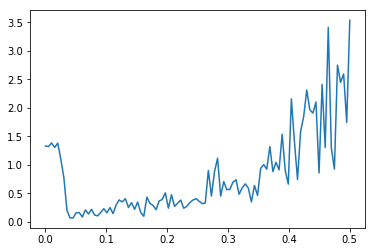

In [14]:
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = rnn.cuda()
lrs, losses = lrfinder(1e-4, 1e-1*5, rnn, trainset_loader)

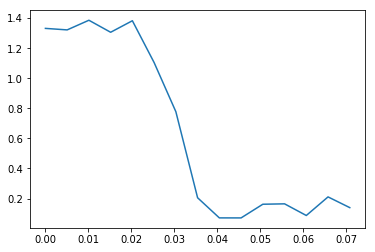

In [15]:
plt.plot(lrs[:15], losses[:15])

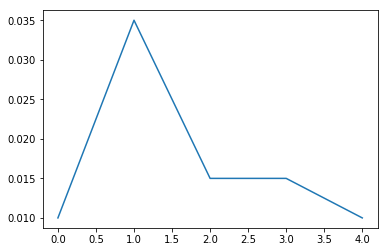

In [14]:
def get_triangular_lr(lr_low, lr_high, mini_batches):
    iterations = mini_batches
    lr_mid = lr_high/7 + lr_low
    up = np.linspace(lr_low, lr_high, int(round(iterations*0.35)))
    down = np.linspace(lr_high, lr_mid, int(round(iterations*0.35)))
    floor = np.linspace(lr_mid, lr_low, int(round(iterations*0.30)))
    return np.hstack([up, down[1:], floor])

lrs_triangular = get_triangular_lr(1e-2, 1e-2*3.5, len(trainset_loader))
plt.plot(lrs_triangular)

In [15]:
clip = 1.0

In [16]:
def train_model(model, lrs_triangular, epochs_number=10, wd=0.0, best_val_loss=float("inf")):
    loss_list = []
    val_list =[]
    optimizer = torch.optim.Adam(rnn.parameters(), lr=lrs_triangular[0], weight_decay=wd)
    for epoch_number in range(epochs_number):
        model.train()
        epoch_loss = []
        for lr, batch in zip(lrs_triangular, trainset_loader):
            optimizer.param_groups[0]['lr'] = lr

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            epoch_loss.append(loss.item())
            loss.backward()

            torch.nn.utils.clip_grad_norm(model.parameters(), clip)

            optimizer.step()

        current_trn_epoch = sum(epoch_loss)/len(trainset_loader)
        print('Training Loss: Epoch:',epoch_number,':', current_trn_epoch)

        current_val_loss = validate(model)
        print('Validation Loss: Epoch:',epoch_number,':', current_val_loss)
        print('')

        val_list.append(current_val_loss)

        if current_val_loss < best_val_loss:

            torch.save(model.state_dict(), 'music_model_padfront_regularized.pth')
            best_val_loss = current_val_loss
    return best_val_loss

In [17]:
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = rnn.cuda()
lrs_triangular = get_triangular_lr(1e-2, 1e-2*3.5, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular)

/home/ubuntu/src/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Training Loss: Epoch: 0 : 1.3214028239250184
Validation Loss: Epoch: 0 : 1.8060027627312984

Training Loss: Epoch: 1 : 0.3098729133605957
Validation Loss: Epoch: 1 : 0.2660364560306828

Training Loss: Epoch: 2 : 0.0739726796746254
Validation Loss: Epoch: 2 : 0.3286161665833968

Training Loss: Epoch: 3 : 0.06684437692165375
Validation Loss: Epoch: 3 : 0.29705935946553347

Training Loss: Epoch: 4 : 0.07347467988729477
Validation Loss: Epoch: 4 : 0.32897441126281396

Training Loss: Epoch: 5 : 0.06813273131847382
Validation Loss: Epoch: 5 : 0.30889202748263916

Training Loss: Epoch: 6 : 0.06938726454973221
Validation Loss: Epoch: 6 : 0.29061854649437

Training Loss: Epoch: 7 : 0.06357002556324005
Validation Loss: Epoch: 7 : 0.31045322217933924

Training Loss: Epoch: 8 : 0.061622243374586105
Validation Loss: Epoch: 8 : 0.29228640492307423

Training Loss: Epoch: 9 : 0.06668211370706559
Validation Loss: Epoch: 9 : 0.28009231204156665



In [18]:
lrs_triangular = get_triangular_lr(1e-3, 1e-2, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=10, wd=1e-4, best_val_loss=best_val_loss)

/home/ubuntu/src/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Training Loss: Epoch: 0 : 0.06734076663851737
Validation Loss: Epoch: 0 : 0.23167542778378838

Training Loss: Epoch: 1 : 0.0523459903895855
Validation Loss: Epoch: 1 : 0.2523915154892372

Training Loss: Epoch: 2 : 0.053994351625442506
Validation Loss: Epoch: 2 : 0.22460134848454896

Training Loss: Epoch: 3 : 0.049139460921287535
Validation Loss: Epoch: 3 : 0.20845769518089322

Training Loss: Epoch: 4 : 0.044452274590730666
Validation Loss: Epoch: 4 : 0.20150456821521598

Training Loss: Epoch: 5 : 0.04634905382990837
Validation Loss: Epoch: 5 : 0.19947308523565963

Training Loss: Epoch: 6 : 0.042546579614281654
Validation Loss: Epoch: 6 : 0.206659587233237

Training Loss: Epoch: 7 : 0.04712603315711021
Validation Loss: Epoch: 7 : 0.1877611004415398

Training Loss: Epoch: 8 : 0.0493565022945404
Validation Loss: Epoch: 8 : 0.20055700413488634

Training Loss: Epoch: 9 : 0.04519732035696507
Validation Loss: Epoch: 9 : 0.1950838215326801



In [19]:
lrs_triangular = get_triangular_lr(1e-4, 1e-2, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=10, wd=1e-4*5, best_val_loss=best_val_loss)

/home/ubuntu/src/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Training Loss: Epoch: 0 : 0.07136875465512275
Validation Loss: Epoch: 0 : 0.21124802786409286

Training Loss: Epoch: 1 : 0.05638705641031265
Validation Loss: Epoch: 1 : 0.23269437168942508

Training Loss: Epoch: 2 : 0.056779724359512326
Validation Loss: Epoch: 2 : 0.2093146134587413

Training Loss: Epoch: 3 : 0.05376745462417602
Validation Loss: Epoch: 3 : 0.1934641034759464

Training Loss: Epoch: 4 : 0.05049195364117622
Validation Loss: Epoch: 4 : 0.23120997647103048

Training Loss: Epoch: 5 : 0.045480745285749434
Validation Loss: Epoch: 5 : 0.20237116745353664

Training Loss: Epoch: 6 : 0.051568730175495146
Validation Loss: Epoch: 6 : 0.18629448524191983

Training Loss: Epoch: 7 : 0.05335976779460907
Validation Loss: Epoch: 7 : 0.18151222883388687

Training Loss: Epoch: 8 : 0.045904020220041274
Validation Loss: Epoch: 8 : 0.216450333120516

Training Loss: Epoch: 9 : 0.04907784759998322
Validation Loss: Epoch: 9 : 0.1931682456484024



In [ ]:
rnn.load_state_dict('music_model_padfront_regularized.pth')

# Validation

In [31]:
def sample_from_piano_rnn(rnn, sample_length=4, temperature=1, starting_sequence=None):

    if starting_sequence is None:
                
        current_sequence_input = torch.zeros(1, 1, 88)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.cuda())
    else:
        current_sequence_input = starting_sequence
        
    final_output_sequence = [current_sequence_input.data.squeeze(1)]

    hidden = None

    for i in range(sample_length):

        output, hidden = rnn(current_sequence_input, [1], hidden)

        probabilities = nn.functional.softmax(output.div(temperature), dim=1)

        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        current_sequence_input = Variable(current_sequence_input.float())

        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    sampled_sequence = torch.cat(final_output_sequence, dim=0).cpu().numpy()
    
    return sampled_sequence

In [21]:
testset = NotesGenerationDataset('Nottingham_data/Nottingham/test/', longest_sequence_length=None)

testset_loader = torch.utils.data.DataLoader(testset, batch_size=1, 
                                            shuffle=True, num_workers=4, drop_last=False)

In [22]:
batch = next(iter(testset_loader))
post_processed_batch_tuple = post_process_sequence_batch(batch)

input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).cuda()

input_sequences_batch_var = input_sequences_batch.cuda()
input_sequences_batch_var.shape

torch.Size([214, 1, 88])

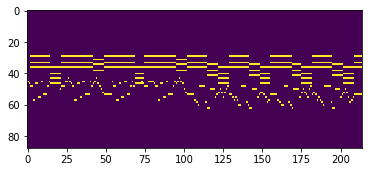

In [24]:
plt.imshow(input_sequences_batch_var.reshape((input_sequences_batch_var.shape[0],88)).transpose(0,1))

/home/ubuntu/src/anaconda3/envs/torch/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


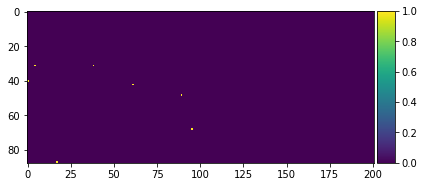

In [32]:
sample = sample_from_piano_rnn(rnn, sample_length=200, temperature=0.7, 
                               starting_sequence=None).transpose()
io.imshow(sample)
midiwrite('sample_reg_018.mid', sample.transpose(), dt=0.3)

In [ ]:
FileLink('sample_025.mid')